# Training demo for the anisotropic dataset

## Import libraries and modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from PIL import Image
from utilities.dataset import *
from utilities.save_load import *
from utilities.FEM_2d_elasticity import *
from utilities.train_network import *
from NN_library.SPD_CNN_modular import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using device: cuda


# Load the dataset

Download and unzip the dataset from Zenodo (doi:10.5281/zenodo.10909619)

In [2]:
data = dataset_3(6)
loaders = get_loaders(data, 32)

## Load the network

In [3]:
name = 'NN_library/NN_6x6_[1, 3]'
args = {'lr' : 0.00001, 'epochs' : 100, 'dev' : dev, 'name' : name, 'train_mode' : 'compliance'}
net = SPD_CNN(res=6, kernels = [1, 3], train_mode=args['train_mode'], input=1)
net = load_network(net, args['name'], args)

## Train the network

In [14]:
losses_train, losses_val = train(net, loaders, args)

Epoch: 0 mean train loss:  7.41430297e-02 mean val. loss:  8.22245851e-02
Epoch: 1 mean train loss:  7.08675801e-02 mean val. loss:  8.14700946e-02
Epoch: 2 mean train loss:  7.08886236e-02 mean val. loss:  8.02059770e-02
Epoch: 3 mean train loss:  7.31980921e-02 mean val. loss:  7.34549239e-02
Epoch: 4 mean train loss:  7.09178319e-02 mean val. loss:  7.02308118e-02
Epoch: 5 mean train loss:  7.26614113e-02 mean val. loss:  6.97131827e-02
Epoch: 6 mean train loss:  7.12770818e-02 mean val. loss:  7.48821497e-02
Epoch: 7 mean train loss:  6.98925851e-02 mean val. loss:  7.06802011e-02
Epoch: 8 mean train loss:  7.07983369e-02 mean val. loss:  7.23143220e-02
Epoch: 9 mean train loss:  7.26387958e-02 mean val. loss:  7.37766325e-02
Epoch: 10 mean train loss:  7.11133918e-02 mean val. loss:  8.54066908e-02
Epoch: 11 mean train loss:  7.10507817e-02 mean val. loss:  7.38340914e-02
Epoch: 12 mean train loss:  7.10744348e-02 mean val. loss:  7.21568018e-02
Epoch: 13 mean train loss:  7.15719

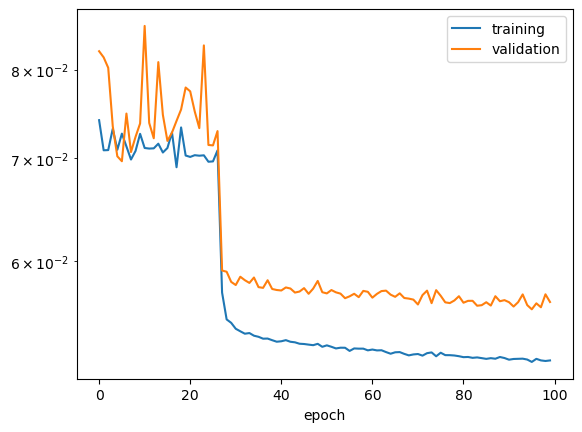

In [16]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.yscale('log')

## Test the network

In [8]:
net = net.to(args['dev'])
net.train_mode = 'compliance'
l_K = 0
l_C = 0
for i, (layout, K, C, zero_map, DBC, f) in enumerate(loaders['test']):
    layout = layout.to(args['dev'])
    K = K.to(args['dev'])
    C = C.to(args['dev'])
    f = f.to(args['dev'])
    DBC = DBC.to(args['dev'])
    K_net, C_net = net(layout, zero_map, DBC, f)
    l_K += Frobenius_norm(K_net, K).sum().detach()
    l_C += Frobenius_norm(C_net, C).sum().detach()

print ('K_grid loss:', f'{l_K.item() / len(loaders["test"].dataset):.4e}')
print ('C_grid loss:', f'{l_C.item() / len(loaders["test"].dataset):.4e}')

3.2886e-02
2.2856e-02


## Print comparison of displacements

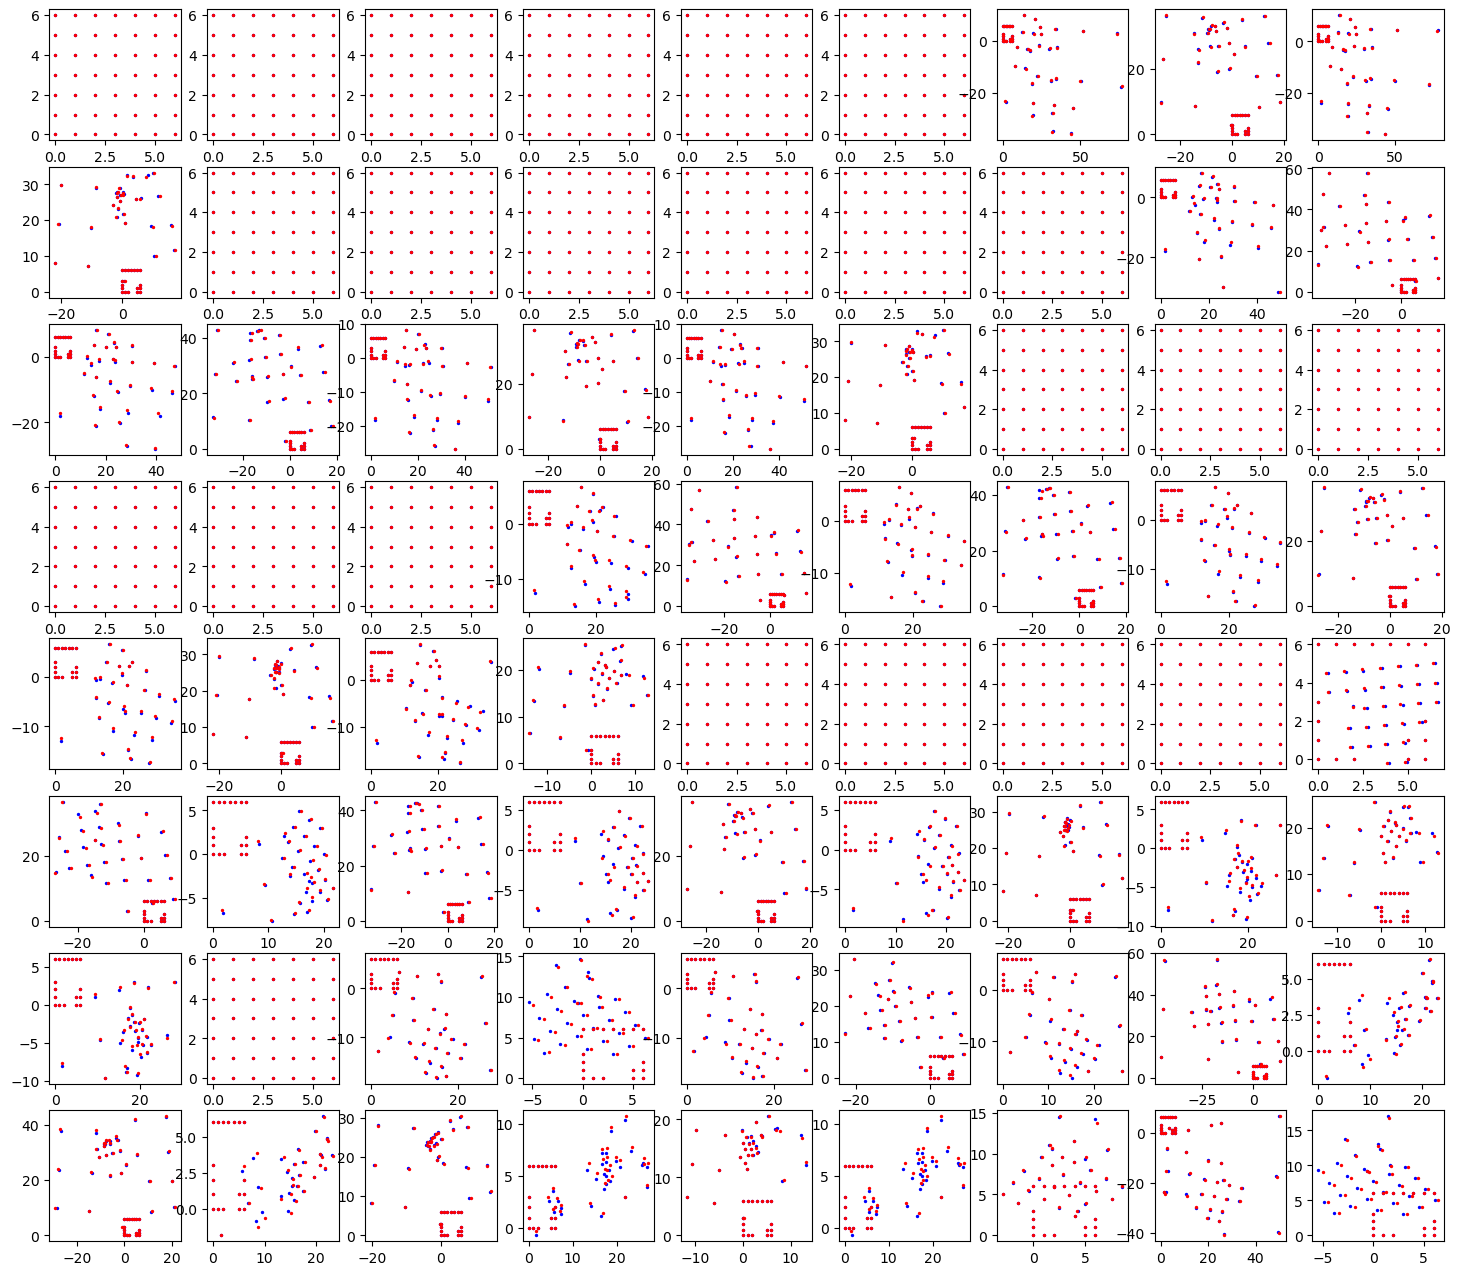

In [22]:
fig, axs = plt.subplots(8, 9, figsize=(18, 16))
x_g, y_g = np.meshgrid(np.arange(7), np.arange(7))
for i in range(8*9):
    axs.flat[i].scatter(x_g.flatten()+1e-1*C[0][i][::2].detach().cpu().numpy(), 
                        y_g.flatten()+1e-1*C[0][i][1::2].detach().cpu().numpy(), s=2, c='b')
    axs.flat[i].scatter(x_g.flatten()+1e-1*C_net[0][i][::2].detach().cpu().numpy(), 
                        y_g.flatten()+1e-1*C_net[0][i][1::2].detach().cpu().numpy(), s=2, c='r')